### **Unzip Dataset**

In [ ]:
#!unzip dataset-30N.zip

### **Installing Libraries**

In [1]:
!pip install thop

### **Import Libraries**

In [2]:
from math import ceil
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import os

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
from collections import defaultdict

import numpy as np
from scipy.signal import savgol_filter
import time
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from PIL import Image
import numpy as np
from sklearn.manifold import TSNE
import pickle
from thop import profile


import json
from PIL import Image as PilImage


### **Set GPU & define labels of dataset**

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
labels_map = {
      0: "apple_pie",
      1: "baby_back_ribs",
      2: "baklava",
      3: "beef_carpaccio",
      4: "beef_tartare",
      5: "beet_salad",
      6: "beignets",
      7: "bibimbap",
      8: "bread_pudding",
      9: "breakfast_burrito",
      10: "bruschetta",
      11: "caesar_salad",
      12: "cannoli",
      13: "caprese_salad",
      14: "carrot_cake",
      15: "ceviche",
      16: "cheese_plate",
      17: "cheesecake",
      18: "chicken_curry",
      19: "chicken_quesadilla",
      20: "chicken_wings",
      21: "chocolate_cake",
      22: "chocolate_mousse",
      23: "churros",
      24: "clam_chowder",
      25: "club_sandwich",
      26: "crab_cakes",
      27: "creme_brulee",
      28: "croque_madame",
      29: "cup_cakes",
}
print(len(labels_map))

30


### **Print device used**

In [4]:
print(device)

cuda


### **Display Dataset Images**

In [5]:
def displayImages(t_dataset,imageFlag):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    if imageFlag==0:
      figure.suptitle("Images before preprocessing")
    else:
     figure.suptitle("Images after preprocessing")   
    for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(t_dataset), size=(1,)).item()
      img, label = t_dataset[sample_idx]
      img=np.array(img).transpose((1,2,0))
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.squeeze())
    print("\n\n\n################################################\n\n\n")
    plt.show()

### **Load Data**

In [6]:
def data_loader(data_dir_input,batch_sizeGiven,input_size,flag=0,test_split=0.1,val_split=0.1):
# Define dataset directory and transforms
  data_dir = data_dir_input #
  
  data_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.554, 0.450, 0.343],[0.231, 0.241, 0.241]),
    transforms.RandomErasing()
  ])


  if flag==1:
    test_temp_dataset = datasets.ImageFolder(data_dir,transform=transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),   
  ]))
    displayImages(test_temp_dataset,0)
    test_temp_dataset = datasets.ImageFolder(data_dir,transform=data_transform)
    displayImages(test_temp_dataset,1)

    data = datasets.ImageFolder(root=data_dir, transform=data_transform)
    # Define train, validation, and test dataset
    dataset_size = len(data)
    test_size = int(test_split * dataset_size)
    val_size = int(val_split * dataset_size)
    train_size = dataset_size - (test_size + val_size)
    train_dataset, test_dataset, val_dataset = td.random_split(data,[train_size, test_size, val_size])  
    print("Train Datset Size After Split",len(train_dataset))
    print("Test Datset Size After Split",len(test_dataset))
    print("Validation Datset Size After Split",len(val_dataset))


    # Create a dictionary to store the number of images per class
    num_images_per_class = defaultdict(int)

    # Iterate over the training dataset and count the number of images in each class
    for image, label in train_dataset:
        num_images_per_class[label] += 1

    # Print the number of images per class
    for label, num_images in num_images_per_class.items():
        print(f"Class {label}: {num_images} images")
  

    # Define the number of classes and generate a list of colors
    num_classes = len(num_images_per_class)
    colors = plt.cm.Set1(np.linspace(0, 1, num_classes))

    # Plot the number of images per class as a bar plot
    #plt.bar(num_images_per_class.keys(), num_images_per_class.values(), color=colors)
    plt.pie(num_images_per_class.values(), labels=num_images_per_class.keys(), colors=colors, autopct='%1.1f%%')
    # Add axis labels and title
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title("Number of images per class in the training dataset")

    # Create a legend
    labels = [f"Class {label}" for label in num_images_per_class.keys()]
    plt.legend([plt.bar(0, 0, color=colors[i])[0] for i in range(len(num_images_per_class))], labels)
    plt.rcParams["figure.figsize"] = (20,20)
    # Show the plot
    plt.show()
    
    return  

  data = datasets.ImageFolder(root=data_dir, transform=data_transform)
  # Define train, validation, and test dataset
  dataset_size = len(data)
  test_size = int(test_split * dataset_size)
  val_size = int(val_split * dataset_size)
  train_size = dataset_size - (test_size + val_size)
  train_dataset, test_dataset, val_dataset = td.random_split(data,[train_size, test_size, val_size])  
 
  train_loader = DataLoader(train_dataset, batch_size=batch_sizeGiven, shuffle=True, drop_last=False, num_workers=0,pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_sizeGiven, shuffle=True, drop_last=False, num_workers=0,pin_memory=True) #shuffle 
  val_loader = DataLoader(val_dataset, batch_size=batch_sizeGiven, shuffle=True, drop_last=False, num_workers=0,pin_memory=True) # shuffle working


  return train_loader,test_loader,val_loader
 

### **Dataset images before and after Preprocessing**

In [7]:
path="/kaggle/input/dataset-30/dataset-30N"
saveFilePath="/kaggle/input/hyperparameters.pkl"
saveModelPath="/kaggle/input"
batch_size=32
inputDimension=(256,256)
#data_loader(path,batch_size,inputDimension,flag=1)




################################################





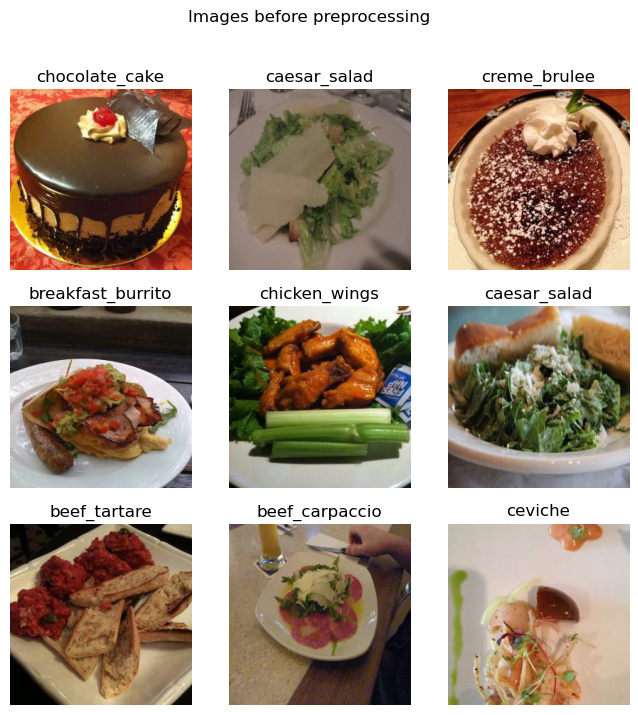




################################################





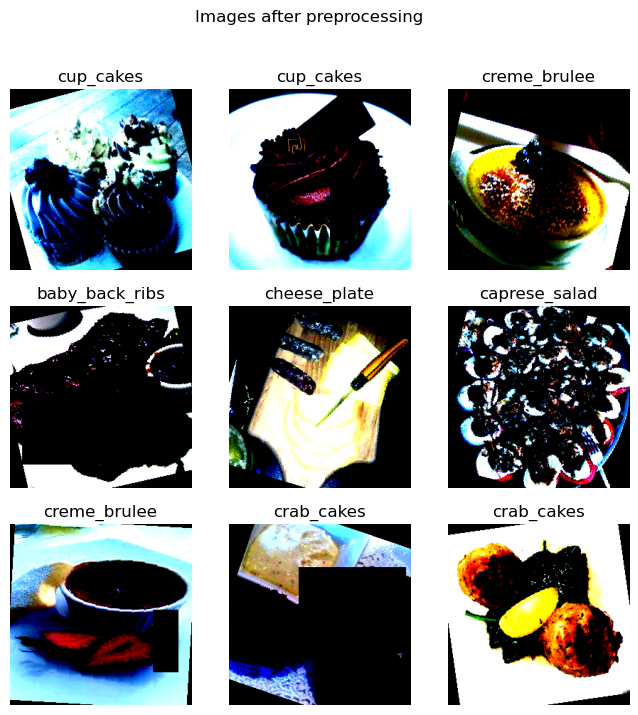

Train Datset Size After Split 24334
Test Datset Size After Split 3041
Validation Datset Size After Split 3041
Class 19: 818 images
Class 24: 766 images
Class 1: 843 images
Class 13: 784 images
Class 26: 796 images
Class 22: 786 images
Class 5: 797 images
Class 12: 814 images
Class 14: 917 images
Class 9: 815 images
Class 17: 799 images
Class 6: 823 images
Class 16: 778 images
Class 3: 805 images
Class 4: 789 images
Class 29: 802 images
Class 2: 805 images
Class 25: 784 images
Class 7: 858 images
Class 10: 791 images
Class 8: 842 images
Class 15: 806 images
Class 0: 797 images
Class 27: 829 images
Class 28: 800 images
Class 18: 800 images
Class 11: 800 images
Class 23: 801 images
Class 20: 840 images
Class 21: 849 images


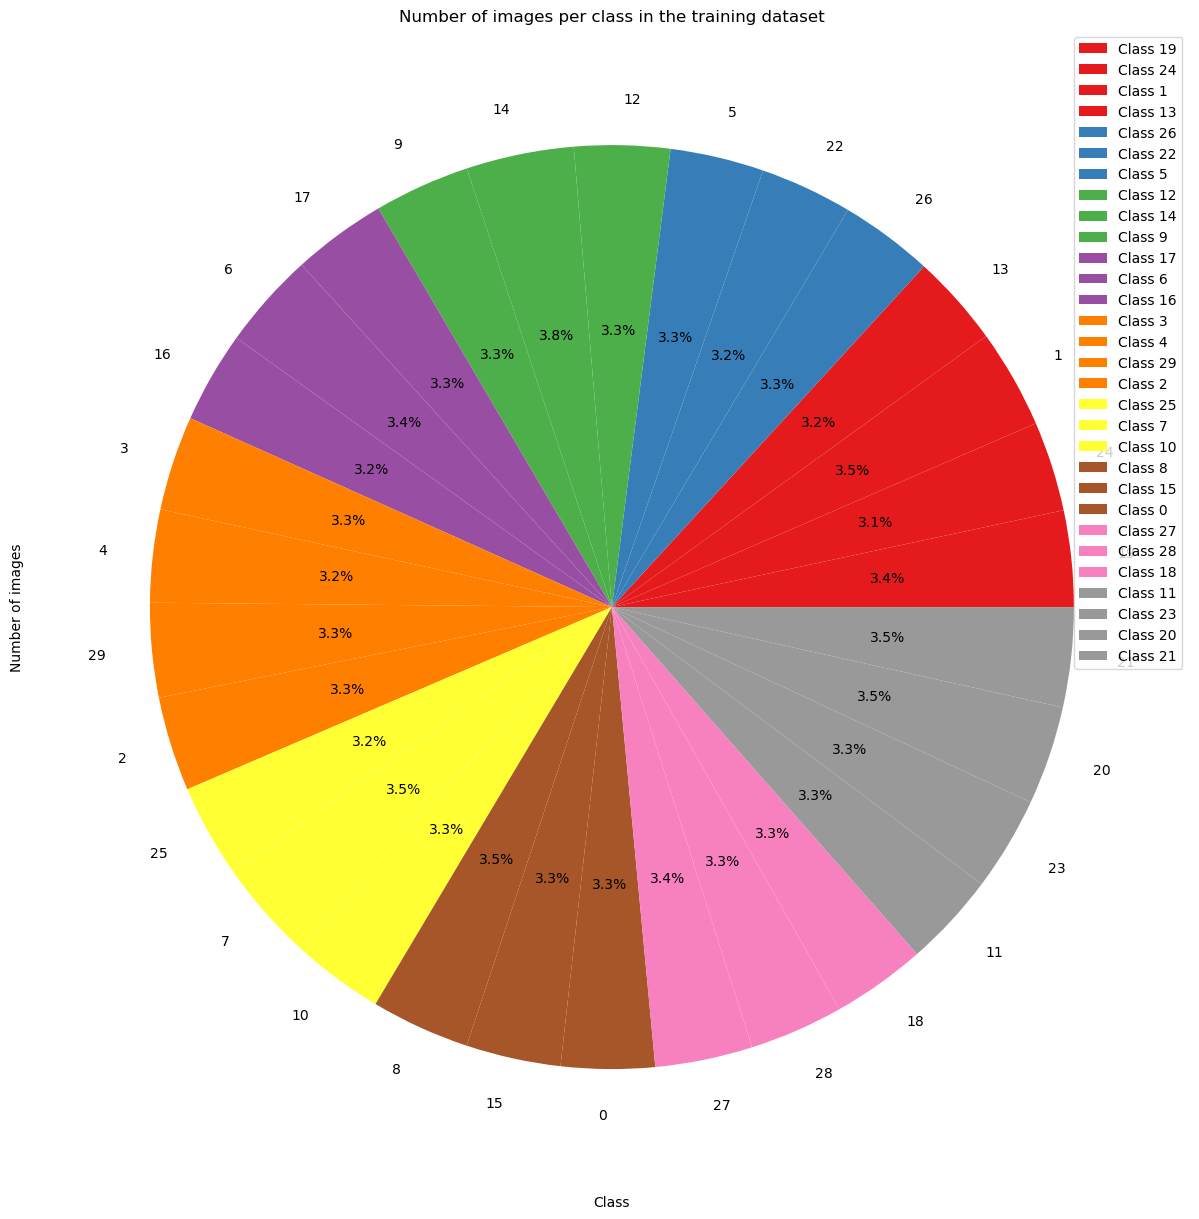

### **Training Loop**

In [8]:
def train(num_epochsGiven, model, train_loader, criterion, optimizer,val_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Device: {}".format(device))
  model.to(device)
  Accuracy=[]
  validAccuracy=[]
  stepAccuracyTotal=[]
  stepAccuracyValidationTotal=[]
  stepLossTotal=[]
  Loss = []
  num_epochs = num_epochsGiven
  total_steps = len(train_loader)
  t1 = time.time()
  total,correct,loss=0,0,0
  for epoch in range(num_epochs):
      stepAcc=[]
      stepLoss=[]    
      for i, data in enumerate(train_loader):
          images, labels = data[0].to(device), data[1].to(device)
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          # Backprop and optimisation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # Train accuracy
          total = labels.size(0)
          _,predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()
          stepAcc.append((correct / total) * 100)
          stepLoss.append(loss.item())
          if (i + 1) % 30 == 0:
              stepAccuracyTotal.append((correct / total) * 100)
              stepLossTotal.append(loss.item())
              correct_v = 0
              total_v = 0
              for dataVal in val_loader:
                  images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
                  outputs = model(images_v)
                  _, predicted = torch.max(outputs.data, 1)
                  correct_v += (predicted == labels_v).sum().item()
                  total_v += labels_v.size(0) 
              stepAccuracyValidationTotal.append((correct_v / total_v) * 100)
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%,Validation Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),(correct / total) * 100,(correct_v / total_v) * 100))     
      correct_v = 0
      total_v = 0
      for dataVal in val_loader:
          images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
          outputs = model(images_v)
          _, predicted = torch.max(outputs.data, 1)
          correct_v += (predicted == labels_v).sum().item()
          total_v += labels_v.size(0)        
      Accuracy.append(sum(stepAcc)/len(stepAcc))
      validAccuracy.append((correct_v / total_v) * 100)
      Loss.append(sum(stepLoss)/len(stepLoss))
  endTime =  time.time()
  print("######## Training Finished in {} seconds ###########".format(endTime-t1))
  print("######## Training timer per epoch is {} seconds ###########".format((endTime-t1)/num_epochsGiven))
  return Loss,Accuracy,model,validAccuracy,stepAccuracyTotal,stepAccuracyValidationTotal,stepLossTotal

### **Testing**

In [9]:
def test(model, device, test_loader):
  model.eval() 
  y_truth=[]
  y_predicted=[]
  cm=[]
  G_correct=0
  G_total=0
  
  with torch.no_grad(): 
      correct = 0
      total = 0
      for data in test_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          y_truth+=labels.cpu().numpy().tolist()
          y_predicted+=predicted.cpu().numpy().tolist()
      print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
      cm= confusion_matrix(y_truth,y_predicted)
      G_total=total
      G_correct=correct
  print(classification_report(y_truth,y_predicted))
  return cm,((G_correct / G_total) * 100)


### **Hyperparameter Tuning**

Learning Rate: 0.0001, Batch Size: 32 , Loss function:  Cross Entropy Loss , Optimizer:  Adam Optimizer
Device: cuda
Epoch [1/15], Step [30/761], Loss: 3.4075, Accuracy: 3.12%,Validation Accuracy: 3.55%
Epoch [1/15], Step [60/761], Loss: 3.3998, Accuracy: 3.12%,Validation Accuracy: 3.03%
Epoch [1/15], Step [90/761], Loss: 3.3908, Accuracy: 3.12%,Validation Accuracy: 3.49%
Epoch [1/15], Step [120/761], Loss: 3.3980, Accuracy: 9.38%,Validation Accuracy: 2.86%
Epoch [1/15], Step [150/761], Loss: 3.3118, Accuracy: 6.25%,Validation Accuracy: 4.67%
Epoch [1/15], Step [180/761], Loss: 3.3673, Accuracy: 6.25%,Validation Accuracy: 5.79%
Epoch [1/15], Step [210/761], Loss: 3.2945, Accuracy: 12.50%,Validation Accuracy: 5.69%
Epoch [1/15], Step [240/761], Loss: 3.2264, Accuracy: 9.38%,Validation Accuracy: 7.27%
Epoch [1/15], Step [270/761], Loss: 3.2627, Accuracy: 12.50%,Validation Accuracy: 6.22%
Epoch [1/15], Step [300/761], Loss: 3.3367, Accuracy: 3.12%,Validation Accuracy: 6.08%
Epoch [1/15], 

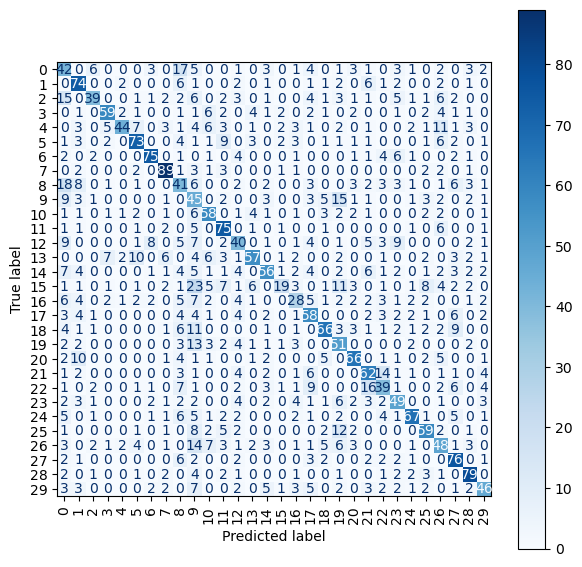

Learning Rate: 0.01, Batch Size: 32 , Loss function:  Cross Entropy Loss , Optimizer:  Adam Optimizer
Device: cuda
Epoch [1/15], Step [30/761], Loss: 3.4979, Accuracy: 0.00%,Validation Accuracy: 3.62%
Epoch [1/15], Step [60/761], Loss: 3.4028, Accuracy: 0.00%,Validation Accuracy: 3.26%
Epoch [1/15], Step [90/761], Loss: 3.4083, Accuracy: 3.12%,Validation Accuracy: 3.42%
Epoch [1/15], Step [120/761], Loss: 3.4197, Accuracy: 3.12%,Validation Accuracy: 3.49%
Epoch [1/15], Step [150/761], Loss: 3.4042, Accuracy: 3.12%,Validation Accuracy: 3.32%
Epoch [1/15], Step [180/761], Loss: 3.4125, Accuracy: 3.12%,Validation Accuracy: 2.63%
Epoch [1/15], Step [210/761], Loss: 3.3970, Accuracy: 3.12%,Validation Accuracy: 3.52%
Epoch [1/15], Step [240/761], Loss: 3.3923, Accuracy: 6.25%,Validation Accuracy: 3.72%
Epoch [1/15], Step [270/761], Loss: 3.4020, Accuracy: 3.12%,Validation Accuracy: 3.32%
Epoch [1/15], Step [300/761], Loss: 3.3980, Accuracy: 6.25%,Validation Accuracy: 3.32%
Epoch [1/15], Step

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


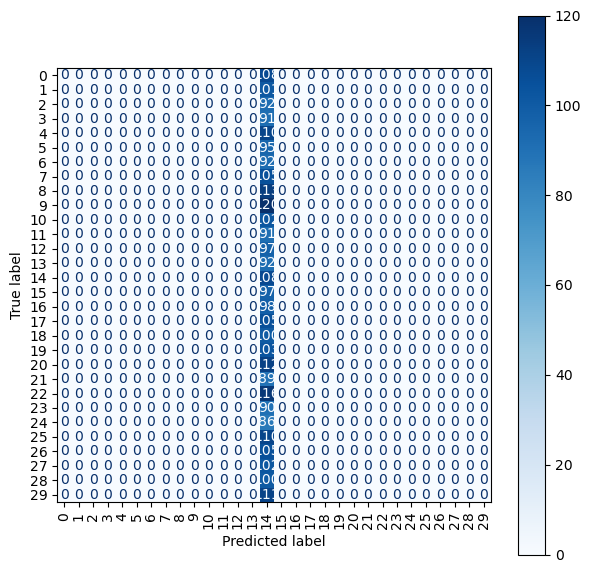

In [10]:
MODELS=[]
hyper_parameters = []
train_acc_hyper_paramaters=[]
train_acc_valid_hyper_paramaters=[]
train_loss_hyper_paramaters=[]

train_acc_hyper_paramaters_step=[]
train_acc_valid_hyper_paramaters_step=[]
train_loss_hyper_paramaters_step=[]
test_loss=[]

#different batch sizes
batch_sizes=[32]
#different learning rates
learning_rates=[0.0001,0.01]
#Setting the number of epochs
epochs=15


for learning_rate in learning_rates:
   for batch_size in batch_sizes:
      #Model VGG11   
      model3 = models.vgg11(weights=None)
      model3.classifier[6] = nn.Linear(4096,len(labels_map))
      stringCrit="Cross Entropy Loss"
      criterion=nn.CrossEntropyLoss()
      #Optimizer Function 
      stringOPTM="Adam Optimizer"
      optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

      hyper_parameters.append(["Learning Rate: "+str(learning_rate)," Batch Size: "+str(batch_size),stringCrit,stringOPTM])
      print("Learning Rate: "+str(learning_rate)+", Batch Size: "+str(batch_size),", Loss function: ",stringCrit,", Optimizer: ",stringOPTM)
      
      train_loader, test_loader, val_loader = data_loader(path,batch_size, inputDimension)
      tempLoss,tempAccuracy,tempModel,tempValidAccuracy,tempStepAccuracy,tempStepValidation,tempStepLoss = train(epochs,model3,train_loader,criterion,optimizer,val_loader)

      
      train_loss_hyper_paramaters.append(tempLoss)
      train_acc_hyper_paramaters.append(tempAccuracy)
      train_acc_valid_hyper_paramaters.append(tempValidAccuracy)

      train_acc_valid_hyper_paramaters_step.append(tempStepValidation)      
      train_acc_hyper_paramaters_step.append(tempStepAccuracy)
      train_loss_hyper_paramaters_step.append(tempStepLoss)

      cmReturned,temp_test_loss = test(model3,"cuda",test_loader)
      test_loss.append([temp_test_loss,learning_rate])
      if cmReturned is not None:
          fig, ax = plt.subplots(figsize=(7, 7))
          ConfusionMatrixDisplay(cmReturned).plot(ax=ax,cmap='Blues', xticks_rotation='vertical', values_format='d')
          plt.show()   
      MODELS.append(tempModel)
  

### **Storing the loss,training accuracy,validation accuracy in a file**

In [11]:
# Saving the lists to a file
saveFilePath="/kaggle/working/hyperparameters.pkl"
saveModelPath="/kaggle/working"
with open(saveFilePath, 'wb') as f:
    data = {
        'hyper_parameters': hyper_parameters,
        'train_acc_hyper_paramaters': train_acc_hyper_paramaters,
        'train_acc_valid_hyper_paramaters': train_acc_valid_hyper_paramaters,
        'train_loss_hyper_paramaters': train_loss_hyper_paramaters,
        'train_acc_hyper_paramaters_step': train_acc_hyper_paramaters_step,
        'train_acc_valid_hyper_paramaters_step': train_acc_valid_hyper_paramaters_step,
        'train_loss_hyper_paramaters_step': train_loss_hyper_paramaters_step,
        'test_loss': test_loss,
    }
    pickle.dump(data, f)



### **Loading the loss,training accuracy,validation accuracy in a file**

In [ ]:
# Loading the lists from the file
with open(saveFilePath, 'rb') as f:
    data = pickle.load(f)
    hyper_parameters = data['hyper_parameters']
    train_acc_hyper_paramaters = data['train_acc_hyper_paramaters']
    train_acc_valid_hyper_paramaters = data['train_acc_valid_hyper_paramaters']
    train_loss_hyper_paramaters = data['train_loss_hyper_paramaters']
    train_acc_hyper_paramaters_step = data['train_acc_hyper_paramaters_step']
    train_acc_valid_hyper_paramaters_step = data['train_acc_valid_hyper_paramaters_step']
    train_loss_hyper_paramaters_step = data['train_loss_hyper_paramaters_step']
    test_loss=data['test_loss']

In [12]:
num_epochs = [(i+1) for i in range(epochs)]
plt.rcParams.update({'font.size': 12})

### **Accuracy Plot(without smoothening)**

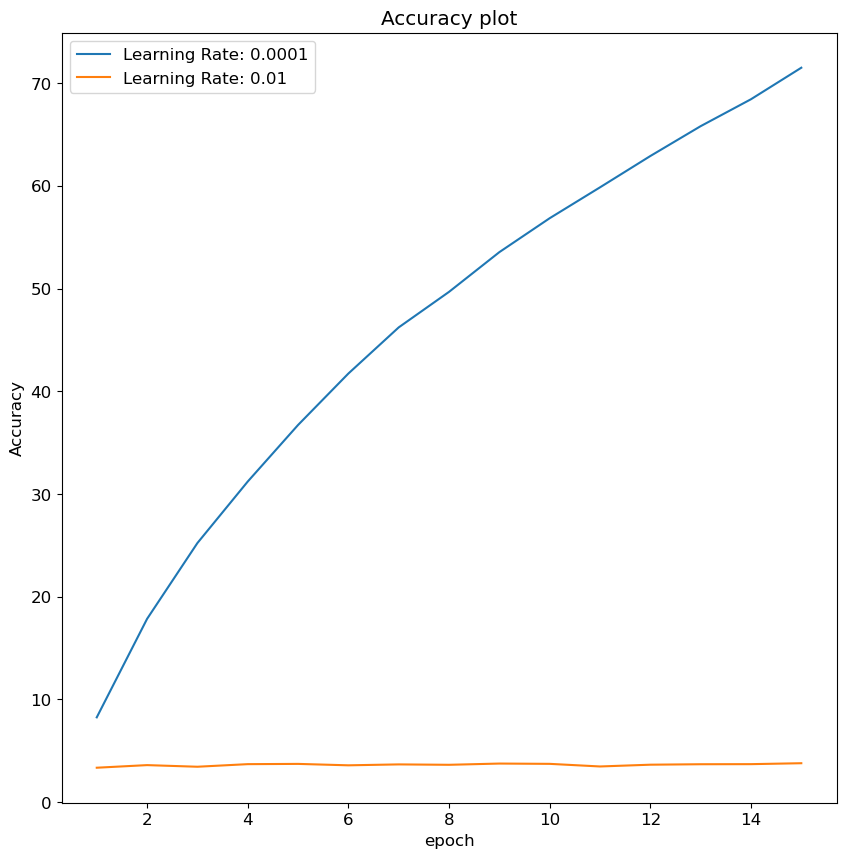

In [15]:
plt.figure(figsize=(10, 10))
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')


for i in range(len(hyper_parameters)):
    plt.plot(num_epochs,train_acc_hyper_paramaters[i],label=hyper_parameters[i][0])
plt.legend()

### **Accuracy Plot(with smoothening)**

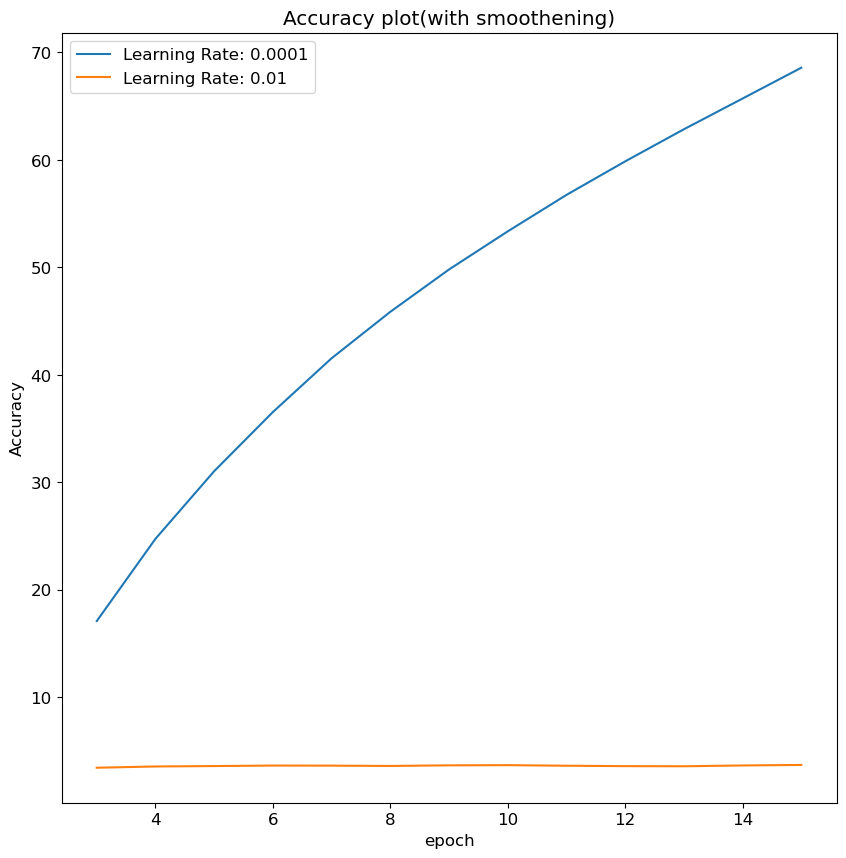

In [16]:
epochs = 15
num_epochs = [(i+1) for i in range(epochs)]
plt.figure(figsize=(10, 10))
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot(with smoothening)')

window_size = 3  # choose the window size for smoothing

for i in range(len(hyper_parameters)):
    accuracy = train_acc_hyper_paramaters[i]
    smoothed_accuracy = np.convolve(accuracy, np.ones(window_size)/window_size, mode='valid')
    plt.plot(num_epochs[-len(smoothed_accuracy):], smoothed_accuracy, label=hyper_parameters[i][0])
plt.legend()

### **Loss Plot(without smoothening)**

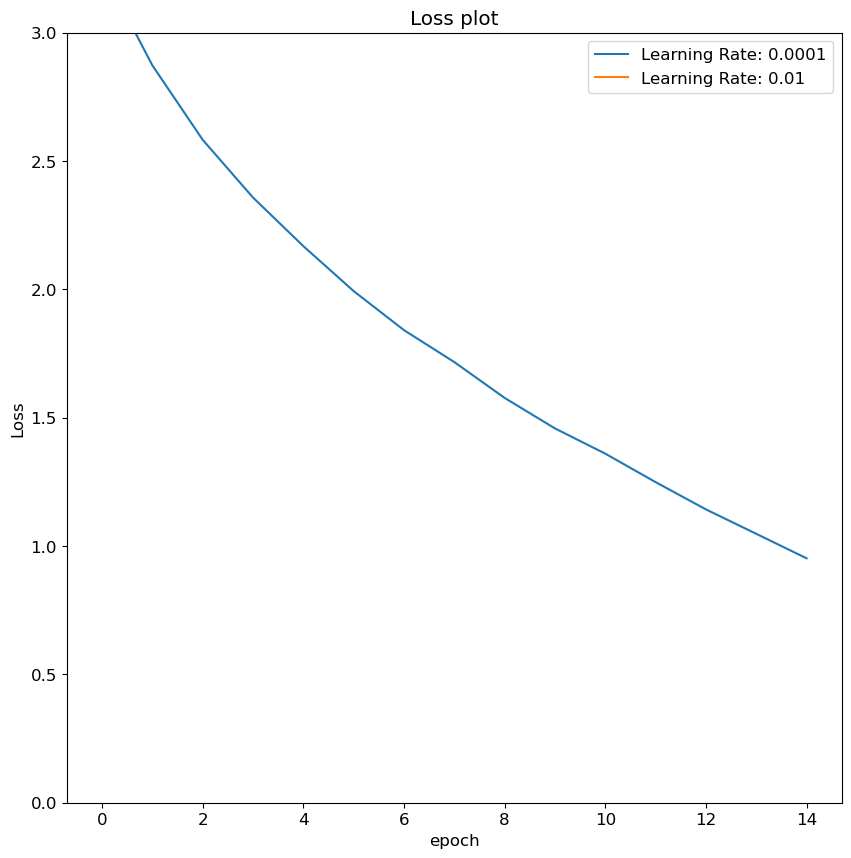

In [17]:
plt.figure(figsize=(10, 10))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.ylim(0,3)
print()

for i in range(len(hyper_parameters)):
    #print(train_loss_hyper_paramaters[i])
    plt.plot(train_loss_hyper_paramaters[i],label=hyper_parameters[i][0])
plt.legend()

### **Loss Plot(with smoothening)**

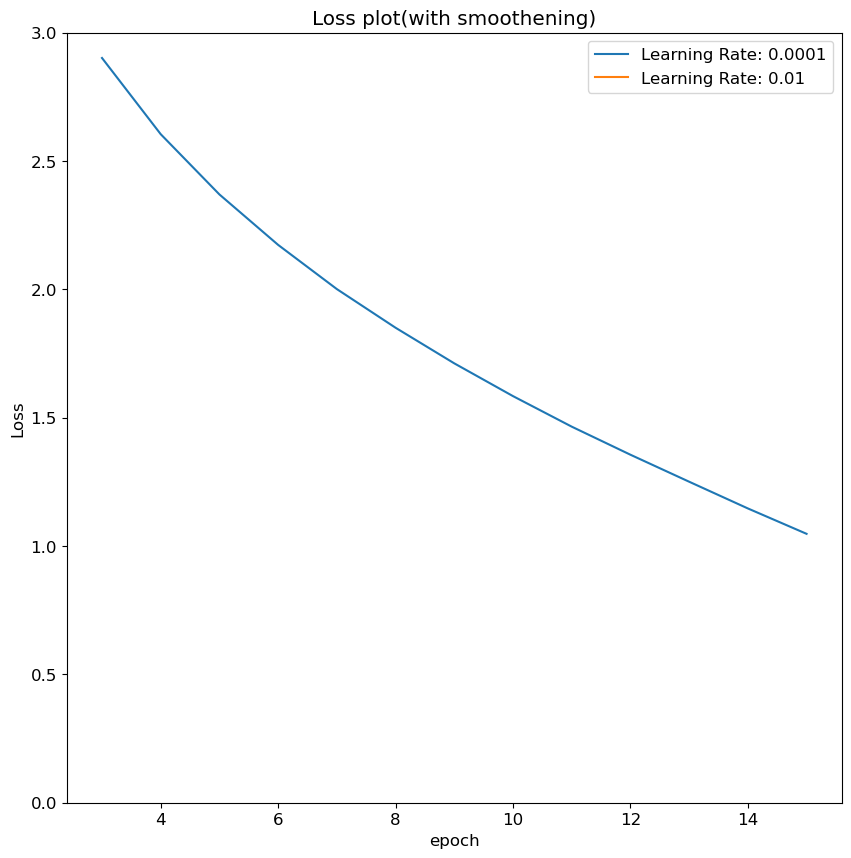

In [18]:

epochs = 15
num_epochs = [(i+1) for i in range(epochs)]
plt.figure(figsize=(10, 10))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot(with smoothening)')
plt.ylim(0,3)
window_size = 3  # choose the window size for smoothing

for i in range(len(hyper_parameters)):
    losses = train_loss_hyper_paramaters[i]
    smoothed_losses = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
    plt.plot(num_epochs[-len(smoothed_losses):], smoothed_losses, label=hyper_parameters[i][0])
    
plt.legend()

### **Loss Plot with respect to steps(without smoothening)**

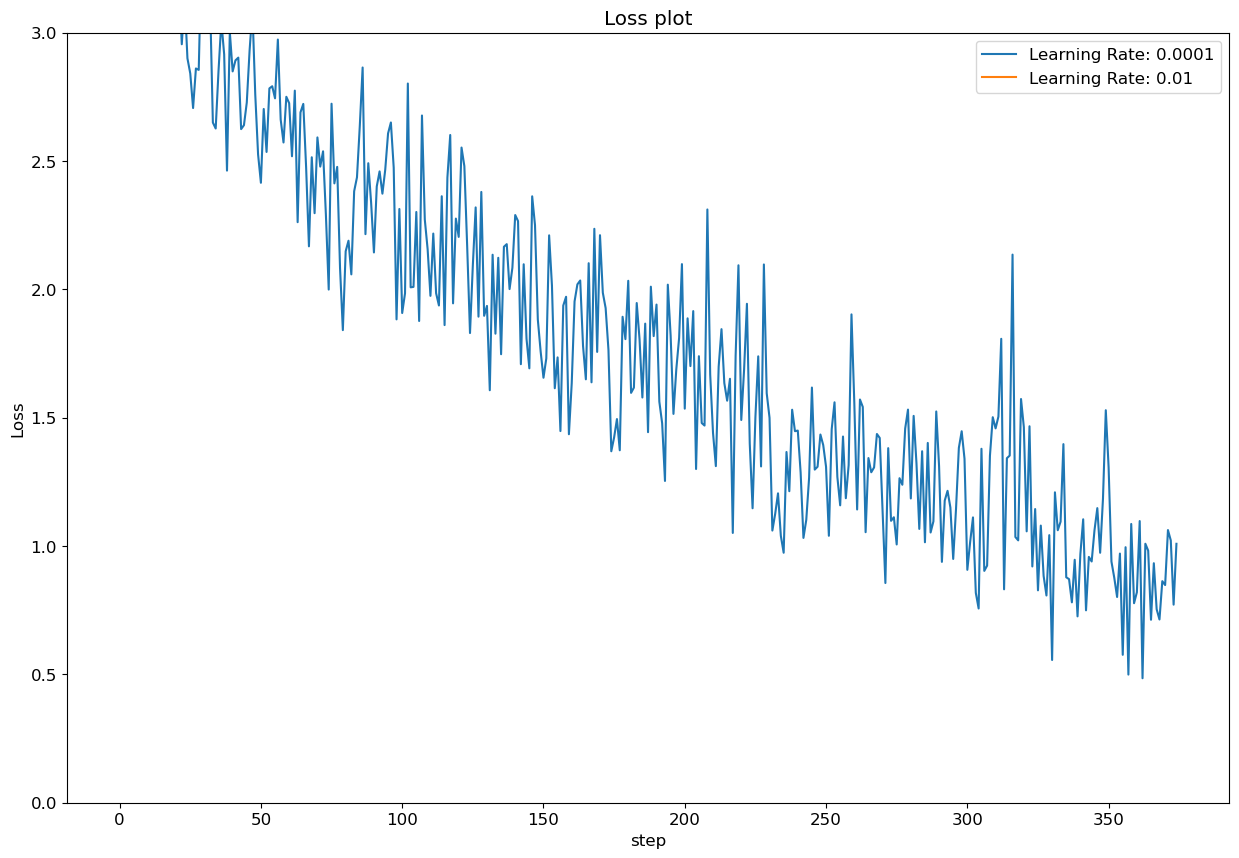

In [19]:
plt.figure(figsize=(15, 10))
plt.xlabel('step')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.ylim(0,3)

for i in range(len(hyper_parameters)):
    plt.plot(train_loss_hyper_paramaters_step[i],label=hyper_parameters[i][0])
plt.legend()

### **Loss Plot with respect to steps(with smoothening)**

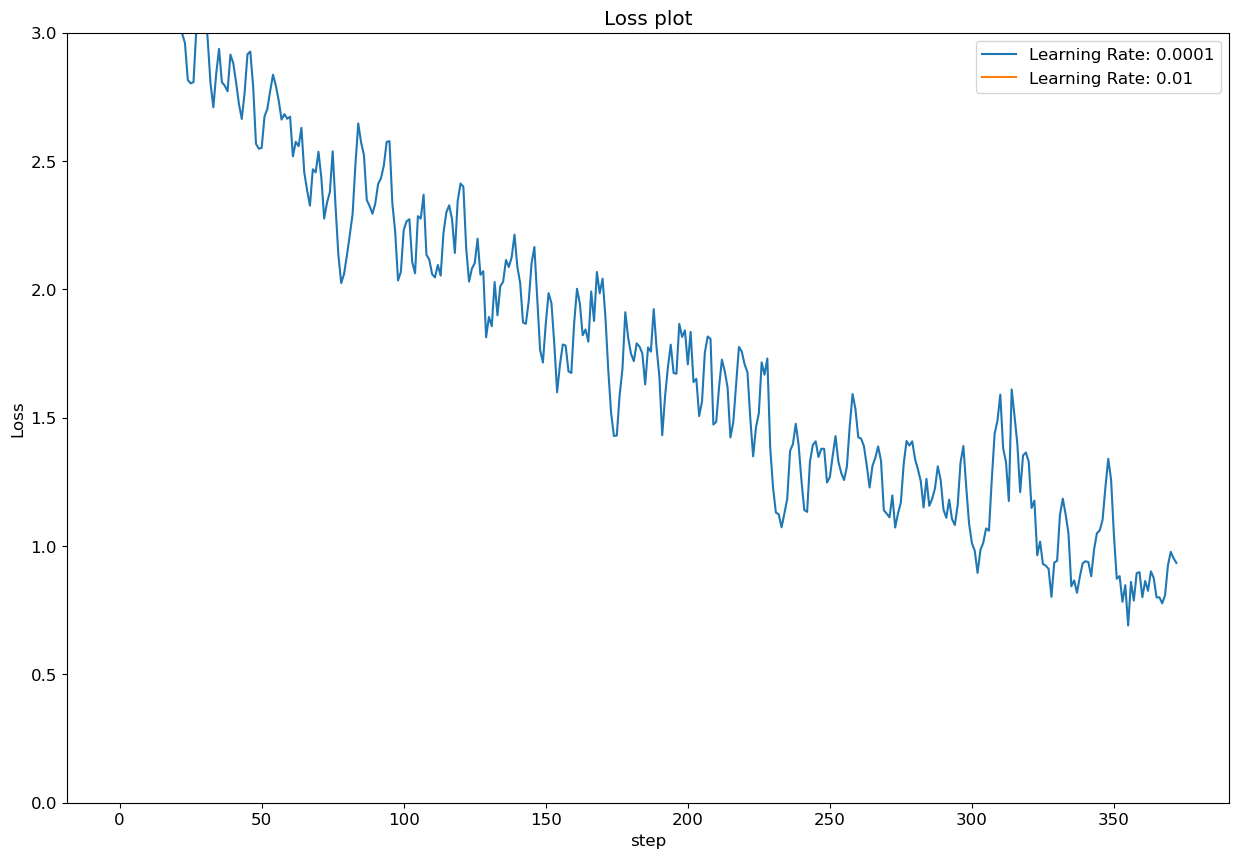

In [20]:
plt.figure(figsize=(15, 10))
plt.xlabel('step')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.ylim(0,3)
window_size = 3

for i in range(len(hyper_parameters)):
    # apply moving average filter to loss values
    smoothed_loss = np.convolve(train_loss_hyper_paramaters_step[i], np.ones(window_size)/window_size, mode='valid')
    plt.plot(smoothed_loss, label=hyper_parameters[i][0])

plt.legend()





### **Test Accuracy and Learning Rate(Scatter plot)**

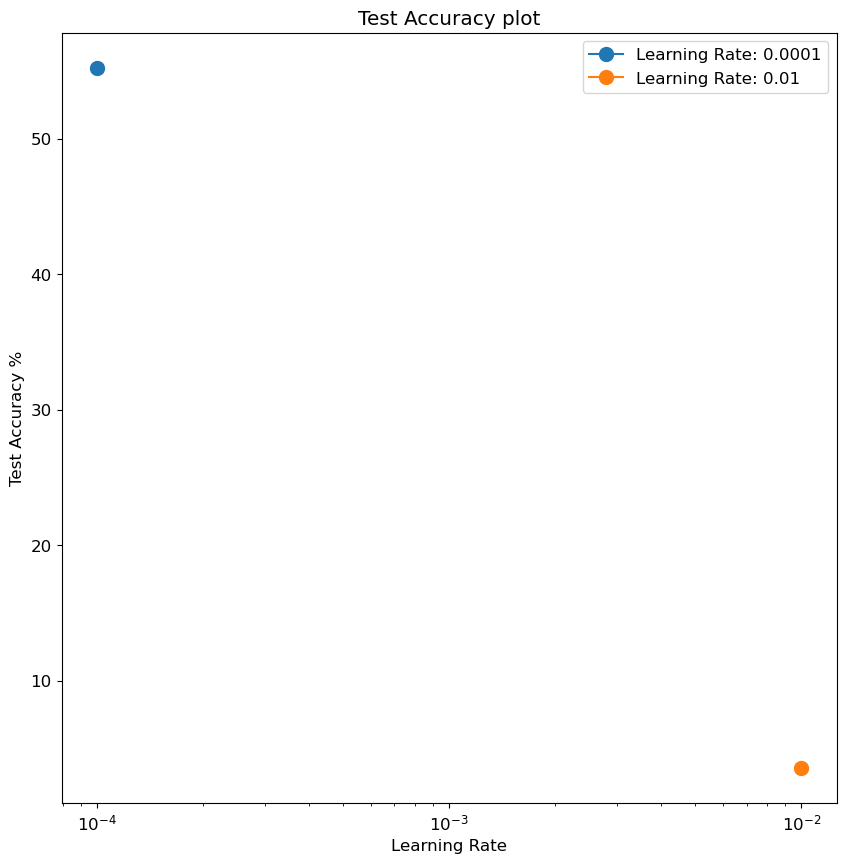

In [22]:
plt.figure(figsize=(10, 10))
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy %')
plt.title('Test Accuracy plot')
plt.xscale("log")

for i in range(len(hyper_parameters)):
    #print(test_loss[i][0],test_loss[i][1])
    plt.plot(test_loss[i][1],test_loss[i][0], marker='o', markersize=10,label=hyper_parameters[i][0])
plt.legend()

### **Training and Validation Plots with respect to epoch**

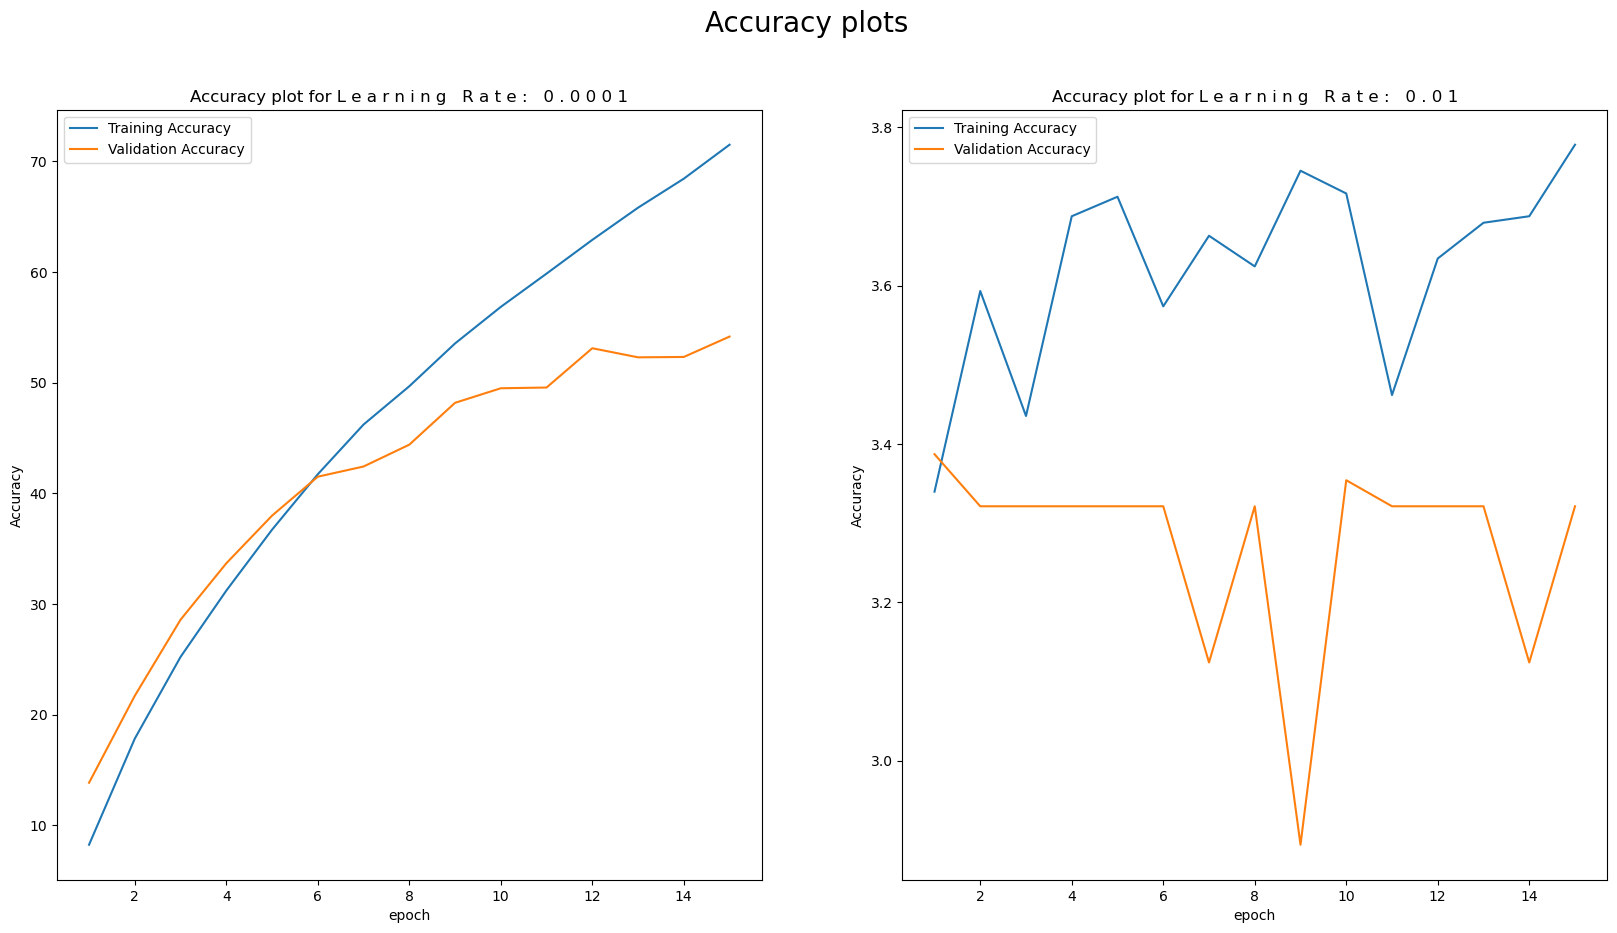

In [39]:
plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig.suptitle('Accuracy plots', fontsize=20)

for i in range(len(hyper_parameters)):
    row = i % 2
    axs[row].plot(num_epochs, train_acc_hyper_paramaters[i], label="Training Accuracy")
    axs[row].plot(num_epochs, train_acc_valid_hyper_paramaters[i],label="Validation Accuracy")
    axs[row].set_xlabel('epoch')
    axs[row].set_ylabel('Accuracy')
    axs[row].set_title('Accuracy plot for ' + " ".join(hyper_parameters[i][0]))
    axs[row].legend()

### **Training and Validation Plots with respect to epoch(with smoothing)**

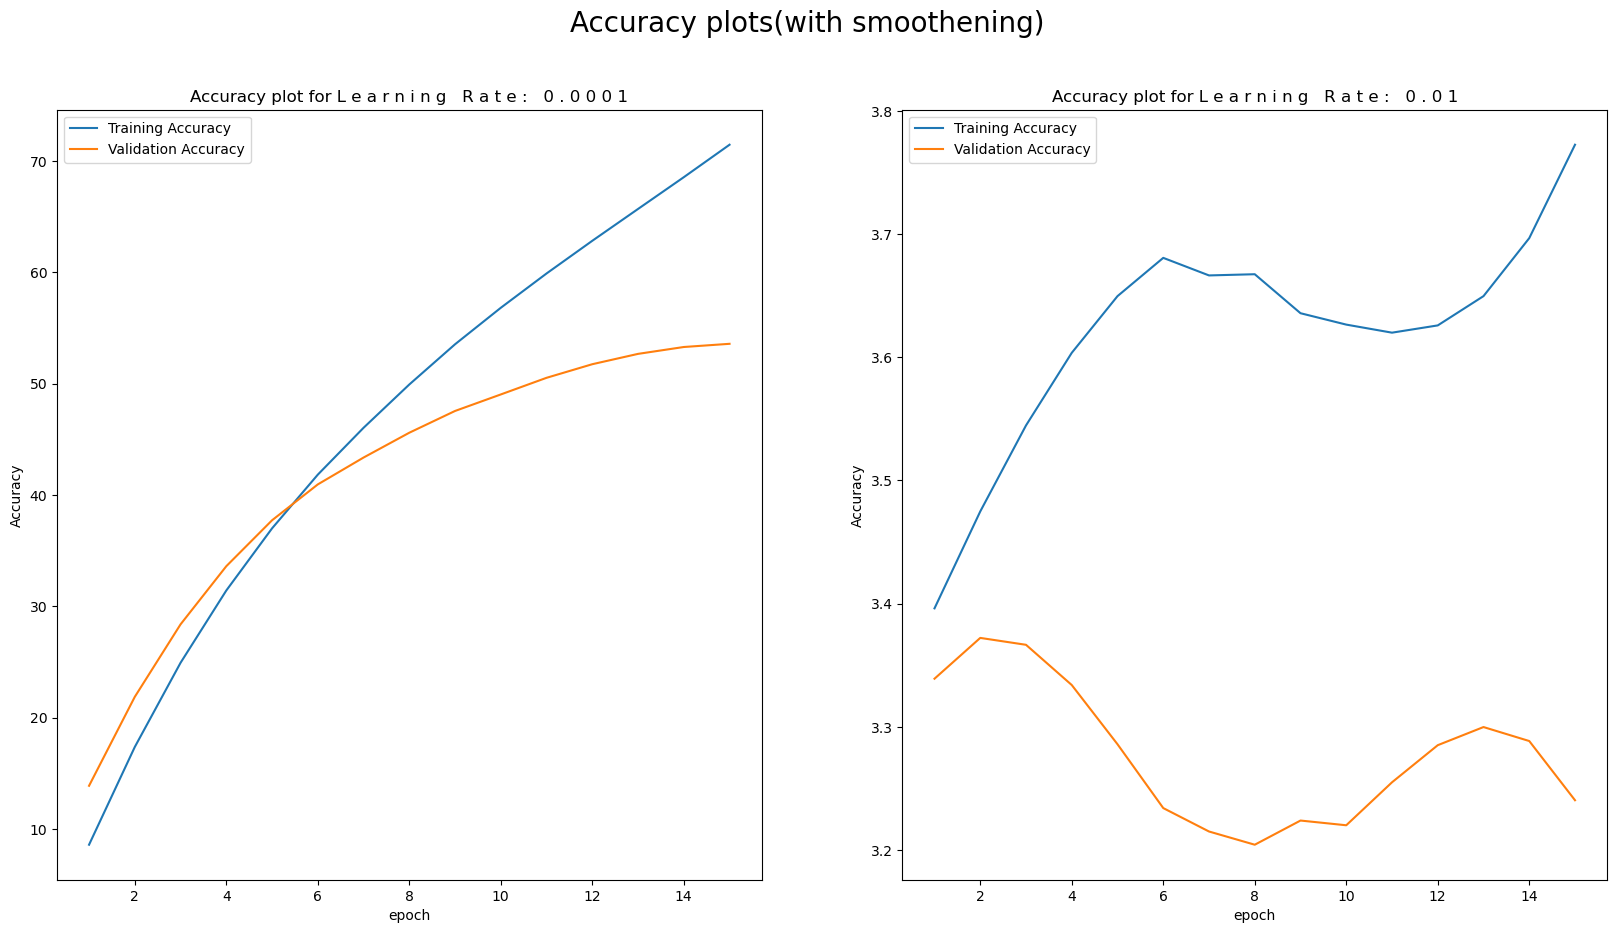

In [42]:


num_epochs = [(i+1) for i in range(epochs)]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig.suptitle('Accuracy plots(with smoothening)', fontsize=20)

for i in range(len(hyper_parameters)):
    row = i % 2
 

    # Smooth the training accuracy curve
    train_acc_smooth = savgol_filter(train_acc_hyper_paramaters[i], window_length=11, polyorder=3)
    axs[row].plot(num_epochs, train_acc_smooth, label="Training Accuracy")

    # Smooth the validation accuracy curve
    val_acc_smooth = savgol_filter(train_acc_valid_hyper_paramaters[i], window_length=11, polyorder=3)
    axs[row].plot(num_epochs, val_acc_smooth, label="Validation Accuracy")

    axs[row].set_xlabel('epoch')
    axs[row].set_ylabel('Accuracy')
    axs[row].set_title('Accuracy plot for ' + " ".join(hyper_parameters[i][0]))
    axs[row].legend()

### **Training and Validation Plots with respect to steps(without smoothing)**

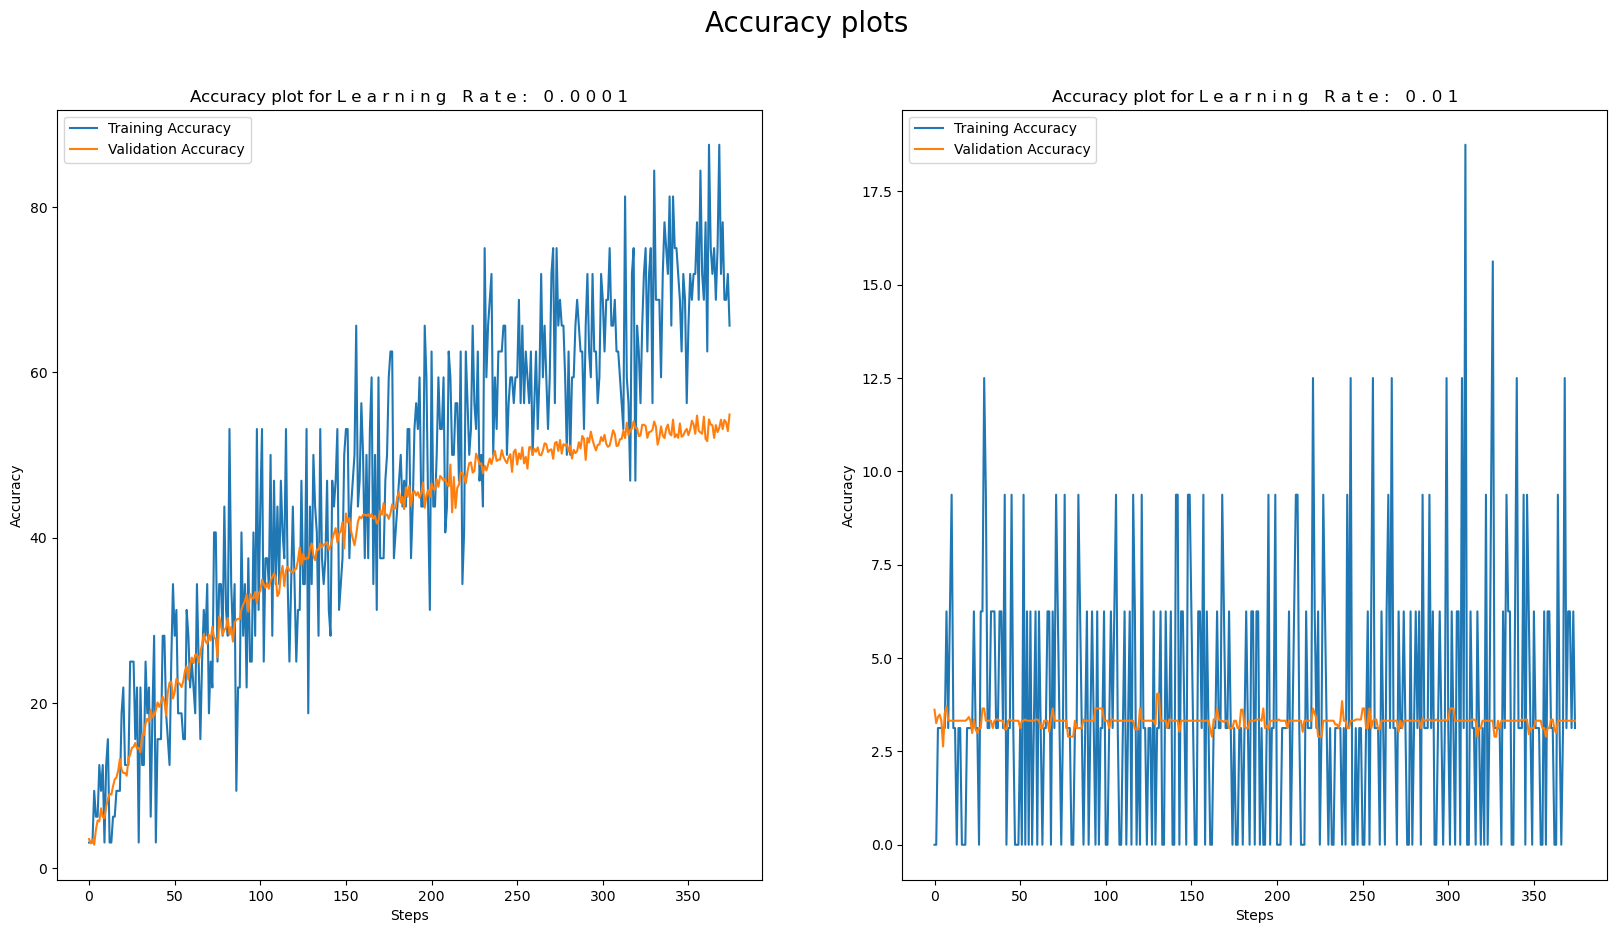

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig.suptitle('Accuracy plots', fontsize=20)

for i in range(len(hyper_parameters)):
    row = i % 2
    #col = i % 2
    axs[row].plot( train_acc_hyper_paramaters_step[i], label="Training Accuracy")
    axs[row].plot(train_acc_valid_hyper_paramaters_step[i],label="Validation Accuracy")
    axs[row].set_xlabel('Steps')
    axs[row].set_ylabel('Accuracy')
    axs[row].set_title('Accuracy plot for ' + " ".join(hyper_parameters[i][0]))
    axs[row].legend()

### **Training and Validation Plots with respect to steps(with Smoothing)**

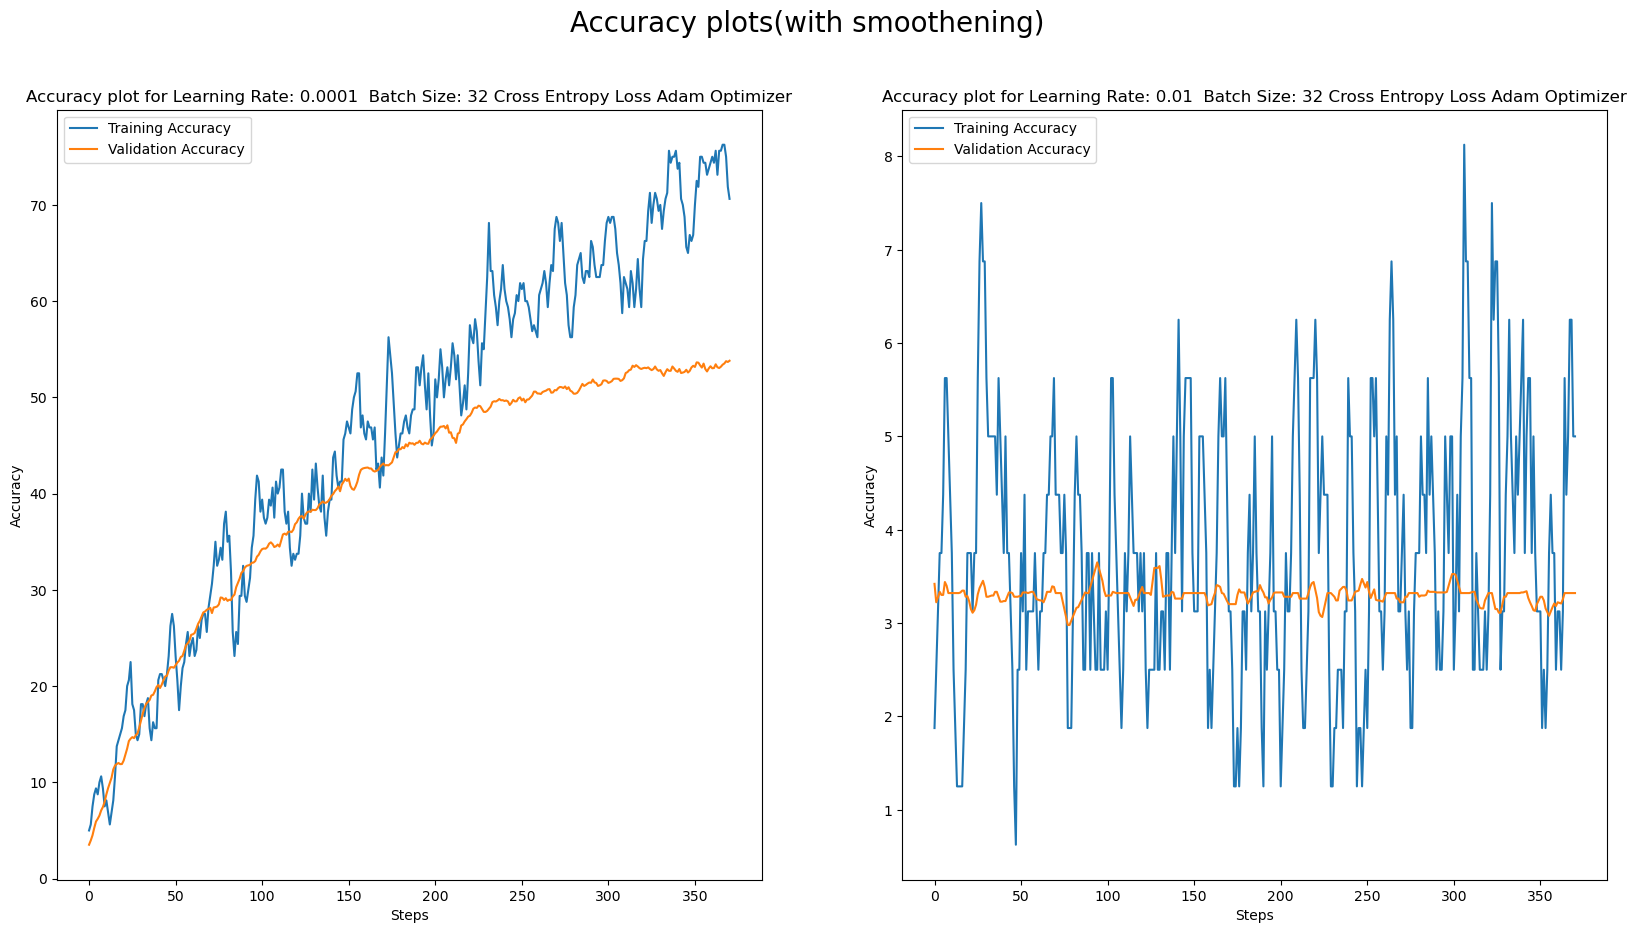

In [45]:

# Define a function to compute the moving average of a list
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Plot the accuracy graphs
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig.suptitle('Accuracy plots(with smoothening)', fontsize=20)

for i in range(len(hyper_parameters)):
    row = i % 2
    #col = i % 2
   
    # Compute the moving average of the training and validation accuracy
    train_acc_smooth = moving_average(train_acc_hyper_paramaters_step[i], 5)
    valid_acc_smooth = moving_average(train_acc_valid_hyper_paramaters_step[i], 5)
   
    # Plot the smoothed accuracy curves
    axs[row].plot(train_acc_smooth, label="Training Accuracy")
    axs[row].plot(valid_acc_smooth, label="Validation Accuracy")
   
    axs[row].set_xlabel('Steps')
    axs[row].set_ylabel('Accuracy')
    axs[row].set_title('Accuracy plot for ' + " ".join(hyper_parameters[i]))
    axs[row].legend()

plt.show()

### **T-SNE Plot (Learning Rate=0.0001)**


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


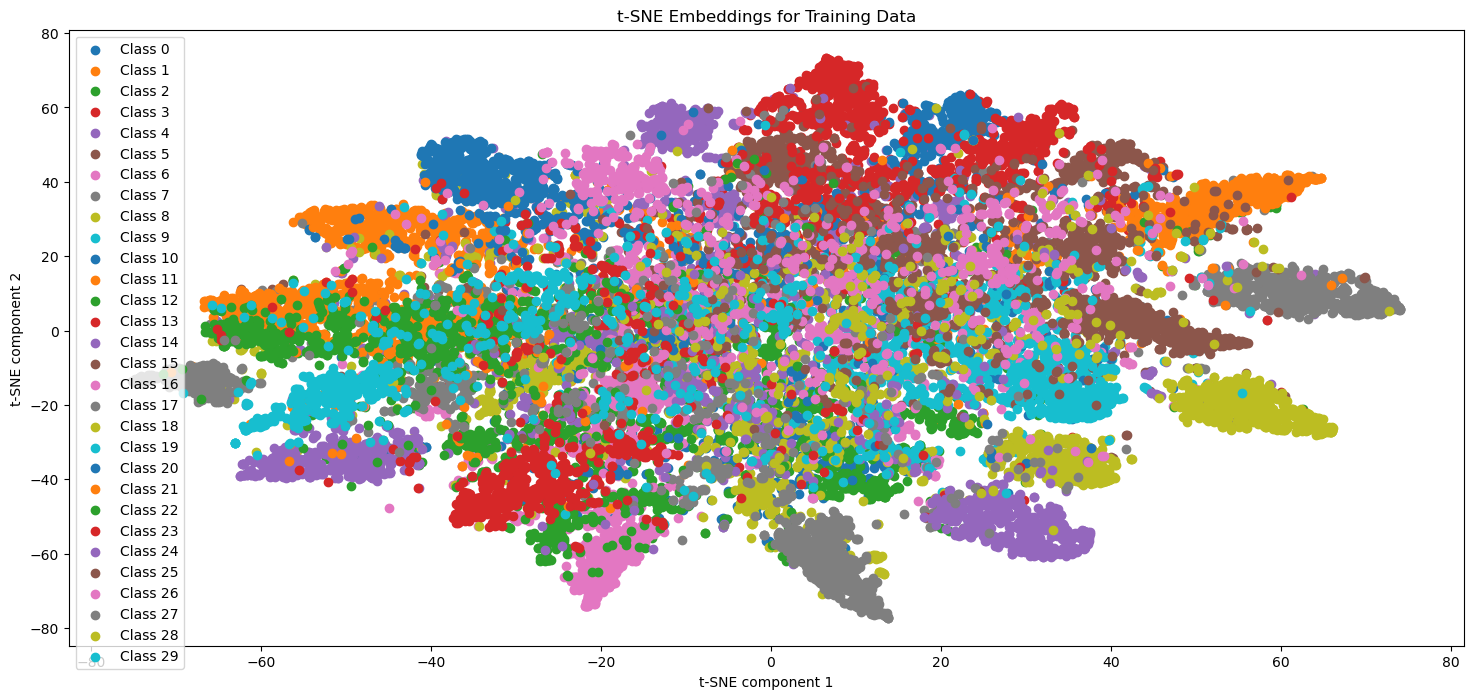

In [47]:
temporaryModel=MODELS[0]

  
  # Get embeddings for the training data
embeddings = []
labels = []
with torch.no_grad():
    for data in train_loader:
        images, targets = data[0].to(device), data[1].to(device)
        outputs = temporaryModel(images)
        embeddings.append(outputs.cpu().numpy())
        labels.append(targets.cpu().numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

  # Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

  # Plot t-SNE embeddings
plt.figure(figsize=(18,8))

for i in range(len(labels_map)):
    plt.scatter(embeddings_tsne[labels==i,0], embeddings_tsne[labels==i,1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE Embeddings for Training Data')
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

### **Saving the Model(Learning Rate=0.0001)**

In [52]:
i=1
saveModelPath="/kaggle/working/"
torch.save(MODELS[0], saveModelPath+"COMP6721_VGG11_Dataset30_Model"+str(i)+".pth")

### **Model FLOPS**

In [49]:
TempTransformer = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.554, 0.450, 0.343],[0.231, 0.241, 0.241]),
    transforms.RandomErasing()
  ])





imageInput = Image.open('/kaggle/input/dataset-30/dataset-30N/cannoli/0.jpg')
input_data = TempTransformer(imageInput)

input_data=input_data.view(1,3,256,256)
print(input_data.size())
#input = torch.randn(1, 3, 256, 256)
alexnet = models.vgg11()
flops, params = profile(alexnet, inputs=(input_data, ))
print(f"FLOPS: {flops / 1e9:.2f} billion")

torch.Size([1, 3, 256, 256])
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
FLOPS: 9.90 billion


### **Output of various models**

In [50]:
TempTransformer = transforms.Compose([
    transforms.Resize(inputDimension),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.554, 0.450, 0.343],[0.231, 0.241, 0.241]),
    transforms.RandomErasing()
  ])

imageInput = Image.open('/kaggle/input/dataset-30/dataset-30N/cannoli/0.jpg')
input_data = TempTransformer(imageInput)
input_data = input_data.to(device)
input_data = input_data.unsqueeze(0)
i=0
for tempModelList in MODELS:
  tempModelList.eval()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  tempModelList.to(device)
  print(" ".join(hyper_parameters[i]))
  with torch.no_grad():
    output = tempModelList(input_data)

  out=output.tolist()[0]
  print(labels_map[out.index(max(out))])
  i=i+1

Learning Rate: 0.0001  Batch Size: 32 Cross Entropy Loss Adam Optimizer
cannoli
Learning Rate: 0.01  Batch Size: 32 Cross Entropy Loss Adam Optimizer
carrot_cake
